In [1]:
import glob
import os, sys
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation")

import torch
import torch.nn as nn
import pandas
import numpy as np
import numpy.ma as ma
import pickle
import time
from tqdm.notebook import tqdm

import proplot as pplt
import sklearn
import re 
from fractions import Fraction

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from utils import *

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
#load model
current_dir = "C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation"
exp_extension = "\\experiments\\poisson_clicks\\"
exp_list = glob.glob(current_dir + exp_extension + "\\exp*19")
exp_list = sorted(exp_list, key = lambda x: int(x.split("Nrec")[-1].split("_")[-1]))
exp_path = exp_list[0]

In [15]:
with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)

training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)

In [16]:
# max_coh = 0.25
max_coh = .5
coherence_list = np.linspace(.0, max_coh, 51)
training_kwargs['coherence_list'] = coherence_list
N_test_batch = 10000
pd = PerceptualDiscrimination(N_batch=N_test_batch, training_kwargs = training_kwargs)
test_x, test_y, test_output_mask, test_trial_params = pd.get_trial_batch() #generate self.N_batch trials
test_set = [test_x, test_y, test_output_mask, test_trial_params]
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs0_0.25.pickle", 'wb') as handle:
#     pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL)
# if max_coh == 0.05:
#     with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs0_0.05.pickle", 'rb') as handle:
#         test_set = pickle.load(handle)
# elif max_coh == 0.25:
#     with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs0_0.25.pickle", 'rb') as handle:
#         test_set = pickle.load(handle)
test_x, test_y, test_output_mask, test_trial_params = test_set

In [17]:
onset_times = np.array([test_trial_params[i]['onset_time']/10. for i in range(len(test_trial_params))], dtype=int)
stim_durations = np.array([test_trial_params[i]['stim_duration']/10. for i in range(len(test_trial_params))], dtype=int)
directions = np.array([test_trial_params[i]['direction'] for i in range(len(test_trial_params))])
cues = np.zeros((test_x.shape[0], test_x.shape[1], 2))

cue_duration = 5
for i in range(onset_times.shape[0]):
    cues[i, onset_times[i]-cue_duration:onset_times[i],0] = 1.
    
output_delay=10
for i in range(onset_times.shape[0]):
    cues[i, onset_times[i]+stim_durations[i]+output_delay:onset_times[i]+stim_durations[i]+output_delay+cue_duration,1] = 1.
    
output_duration = 20
test_y = np.zeros((test_x.shape[0], test_x.shape[1], 2))
for i in range(onset_times.shape[0]):
    test_y[i, onset_times[i]+stim_durations[i]+output_delay+cue_duration:onset_times[i]+stim_durations[i]+output_delay+cue_duration+output_duration,directions[i]] = 1.

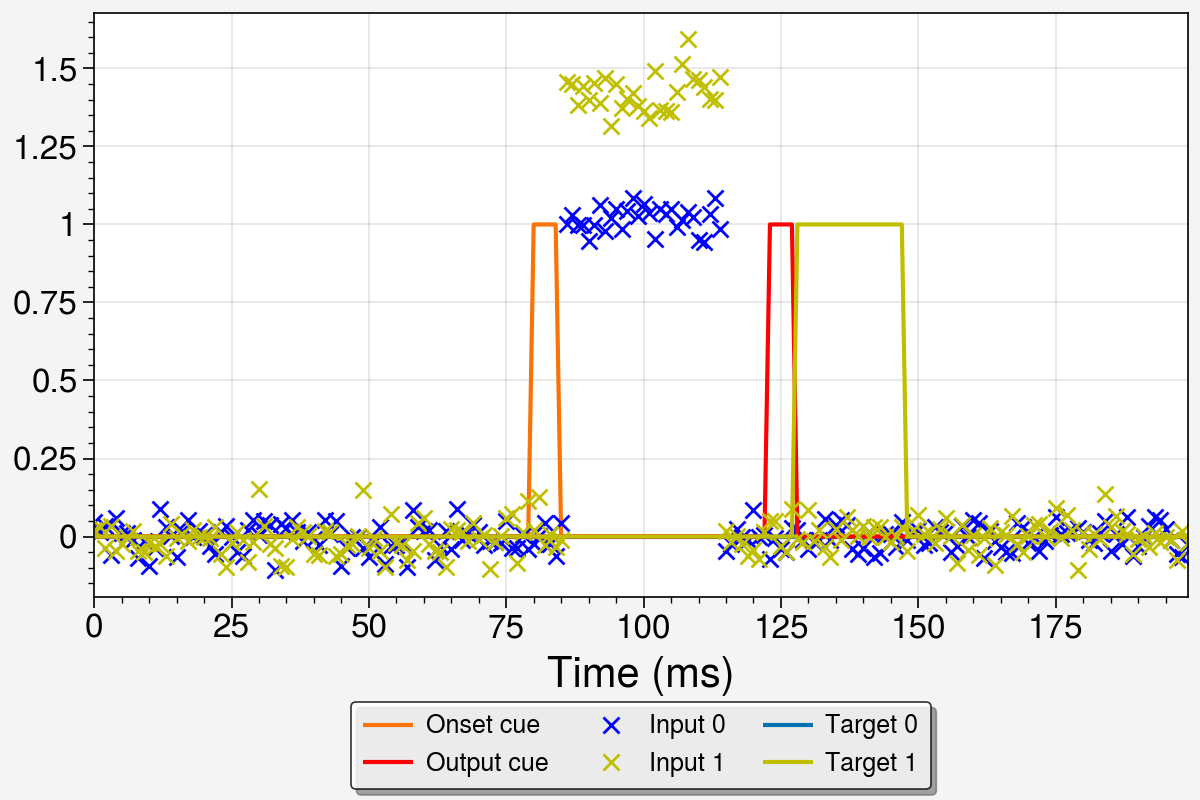

In [18]:
pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
trial_i = 101

ax.plot(cues[trial_i,:,0], '-', color='orange', label = "Onset cue")
ax.plot(test_x[trial_i,:,0], 'bx',  label = "Input 0") 
ax.plot(test_y[trial_i,:,0], '-',  label="Target 0")

ax.plot(cues[trial_i,:,1], '-', color='red', label="Output cue")
ax.plot(test_x[trial_i,:,1], 'yx', label='Input 1')
ax.plot(test_y[trial_i,:,1], 'y-', label='Target 1')

ax.set_xlabel("Time (ms)")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
          fancybox=True, shadow=True, ncol=3)

plt.savefig(training_kwargs['figures_path'] + "\\example_trial_setup.pdf")

plt.savefig(current_dir + exp_extension + "/example_dotmot_trial.pdf")
plt.savefig(current_dir + exp_extension + "/example_dotmot_trial.png")

In [19]:
test_x = np.concatenate((test_x, cues), axis=-1)
inputs = torch.tensor(test_x, dtype=torch.float)

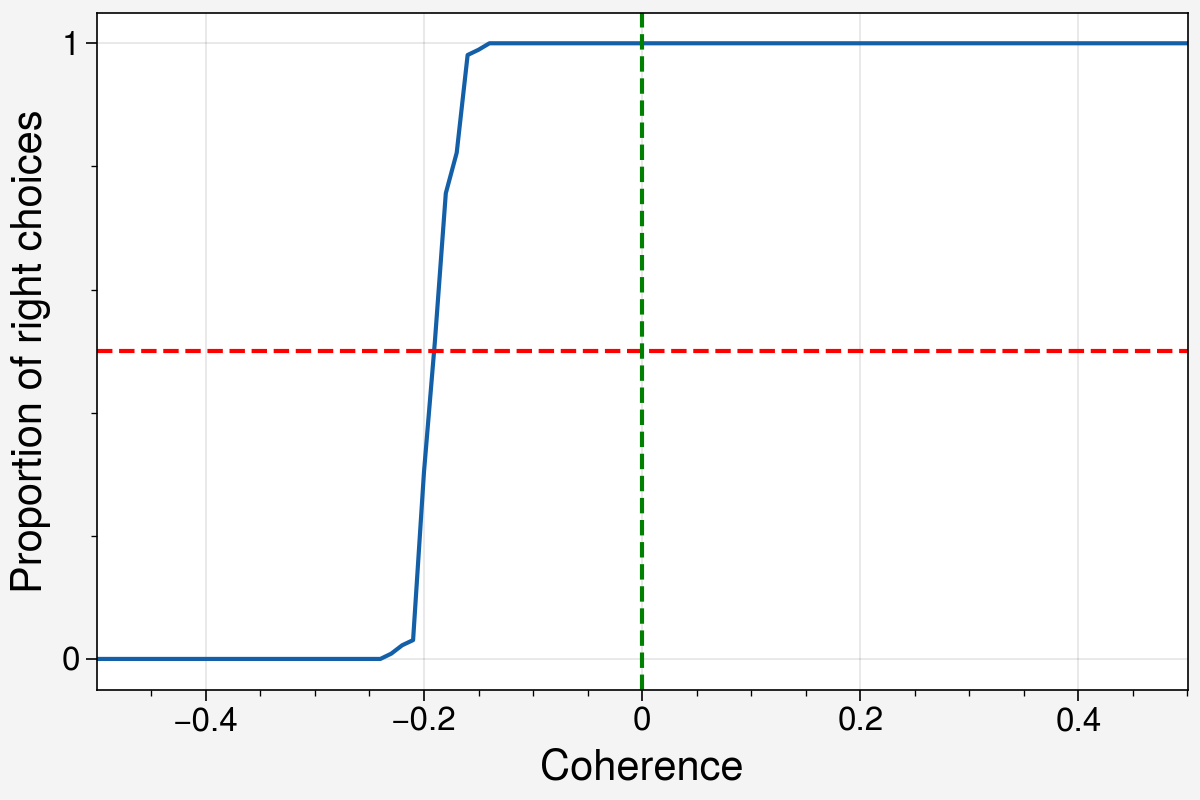

In [20]:
pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
cm = plt.get_cmap('blues')
cnorm = matplotlib.colors.Normalize(vmin=0, vmax=1)
smap = matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cm)
faulty=0
for exp_path in exp_list:
    with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
        training_kwargs = pickle.load(handle)

    training_kwargs['exp_path'] = exp_path
    training_kwargs['training_weights_path'] = exp_path+'/training/'
    training_kwargs['figures_path'] = exp_path + '//figures/'
    idx = int(re.search(r'\d+', exp_path).group())

    rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
    rnn_model = load_model(rnn_model, training_kwargs)
    
    weight_list = glob.glob(training_kwargs['training_weights_path']+'\\*')
    # weight_list.remove(training_kwargs['training_weights_path']+"\weights_epochstart_5.pth") #better way to remove start? Or just store it differently...

    for file in weight_list:
        lastbit = file.split("weights",1)[1].split("_",1)[-1]
        epoch = lastbit.split("epoch",1)[1].split("_",1)[0]
        # print(epoch)

    weight_list = sorted(weight_list, key = lambda x: int(x.split("epoch")[-1].split(".")[-2]))
    weight_list = sorted(weight_list, key = lambda x: (1/float(x.split("coh")[-1].split("_")[-3]), int(x.split("epoch")[-1].split(".")[-2])))

    weight_path = weight_list[-111]
    rnn_model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))

    rnn_model.eval();
    yhat, hidden = rnn_model(inputs)
    yhat_np = yhat.detach().numpy()

    all_directed_coherences, average_accuracy_per_coherence = get_correctness_curve(test_y, yhat_np, test_output_mask, test_trial_params)
    all_directed_coherences, average_choice_per_coherence = get_psycho_curve(test_y, yhat_np, test_output_mask, test_trial_params)
    
    accuracy = np.mean(average_accuracy_per_coherence)
    # plt.plot(all_directed_coherences, 1-average_accuracy_per_coherence, c=smap.to_rgba(training_kwargs['N_rec']), label=training_kwargs['N_rec'])
    plt.plot(all_directed_coherences, 1-average_choice_per_coherence, c=smap.to_rgba(accuracy), label=training_kwargs['N_rec'])

    # print(accuracy)

ax.set_xlabel("Coherence")
ax.set_ylabel("Proportion of right choices")
ax.set_yticks([0,1])
ax.axhline(y = 0.5, color = 'r', linestyle = '--')
ax.axvline(x = 0, color = 'g', linestyle = '--')
# plt.legend()
plt.savefig(current_dir + exp_extension + "/psycho_pdtask_all.pdf")
plt.savefig(current_dir + exp_extension + "/psycho_pdtask_all.png")

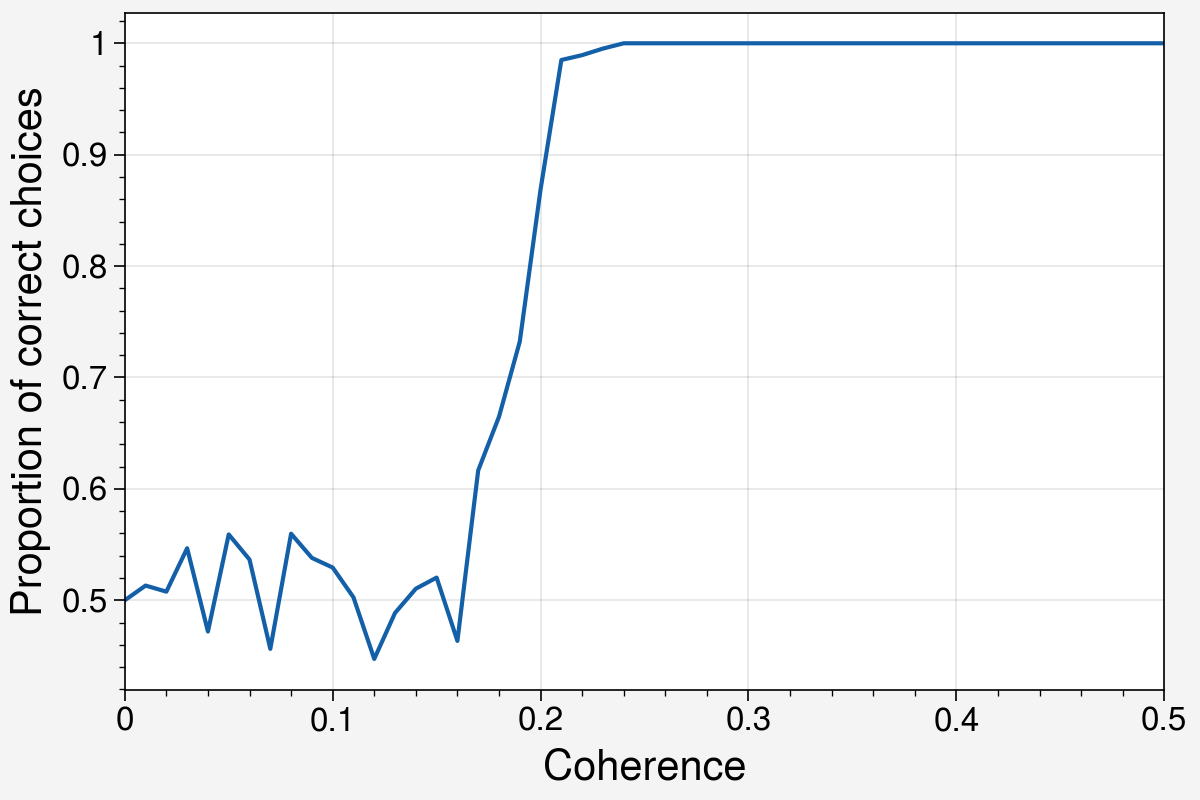

In [21]:
#accuracy vs coherence, with direction
inputs = torch.tensor(test_x, dtype=torch.float)

label_size = 12
pplt.rc['tick.labelsize'] = label_size 
pplt.rc['axes.labelsize'] = label_size + 3

pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
cmap = cm = plt.get_cmap('blues')
# cnorm = matplotlib.colors.Normalize(vmin=1, vmax=10)
cnorm = matplotlib.colors.Normalize(vmin=0, vmax=1)
smap = matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cm)
faulty=0
for exp_path in exp_list:
    with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
        training_kwargs = pickle.load(handle)

    training_kwargs['exp_path'] = exp_path
    training_kwargs['training_weights_path'] = exp_path+'/training/'
    training_kwargs['figures_path'] = exp_path + '//figures/'
    idx = int(re.search(r'\d+', exp_path).group())

    rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
    # try: #there seems to be a problem with python version? 3.8 vs 3.9??
    #     rnn_model = load_model(rnn_model, training_kwargs)
    # except:
    #     faulty += 1
    #     continue
    
    weight_list = glob.glob(training_kwargs['training_weights_path']+'\\*')
    # weight_list.remove(training_kwargs['training_weights_path']+"\weights_epochstart_5.pth") #better way to remove start? Or just store it differently...

    for file in weight_list:
        lastbit = file.split("weights",1)[1].split("_",1)[-1]
        epoch = lastbit.split("epoch",1)[1].split("_",1)[0]
        # print(epoch)

    weight_list = sorted(weight_list, key = lambda x: int(x.split("epoch")[-1].split(".")[-2]))
    weight_list = sorted(weight_list, key = lambda x: (1/float(x.split("coh")[-1].split("_")[-3]), int(x.split("epoch")[-1].split(".")[-2])))

    weight_path = weight_list[-111]
    rnn_model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
    
    rnn_model.eval();
    yhat, hidden = rnn_model(inputs)
    yhat_np = yhat.detach().numpy()
    
    
    all_directed_coherences, average_accuracy_per_coherence = get_correctness_curve(test_y, yhat_np, test_output_mask, test_trial_params)
    all_directed_coherences, average_choice_per_coherence = get_psycho_curve(test_y, yhat_np, test_output_mask, test_trial_params)
    accuracy = np.mean(average_accuracy_per_coherence)

    # ratio_array = np.array([test_trial_params[i]['ratio'] for i in range(test_trial_params.size)])
    # ratios = np.unique(ratio_array)
    # accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index = get_accuracy_poissonclicks(test_x, yhat_np, test_output_mask, test_trial_params)
    # print("Accuracy:", accuracy)
    
    plt.plot(coherence_list, average_accuracy_per_coherence, c=smap.to_rgba(accuracy), label=training_kwargs['N_rec'])
    # plt.plot(coherence_list, average_accuracy_per_coherence, c=smap.to_rgba(training_kwargs['N_rec']), label=training_kwargs['N_rec'])
    
    
    # plt.plot(ratios, average_accuracy_per_ratio, c=smap.to_rgba(training_kwargs['N_rec']), label=training_kwargs['N_rec'])
ax.set_xlabel("Coherence")
ax.set_ylabel("Proportion of correct choices")
# plt.legend(title='N')
plt.savefig(current_dir + exp_extension + "/correct_pdtask_all.pdf")
plt.savefig(current_dir + exp_extension + "/correct_pdtask_all.png")